# Azure Data University: mlos_bench MySQL data analysis

In this notebook, we will look at some data we've collected with `mlos_bench` while optimizing MySQL Server configuration for Azure.

### 1. Import packages

First, import some standard Python packages for data manipulation and plotting.

We'll also use the `mlos_bench` Storage API to retrieve the data from our experiments.

In [1]:
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

from mlos_bench.storage import from_config

In [2]:
# Cosmetic: Suppress some annoying warnings from third-party data visualization packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 2. Connect to the DB using existing mlos_bench configs

We reuse the existing `mlos_bench` framework configuration file that contains the DB connection parameters. This way we make sure to connect to the same database that our framework uses to store the experimental data.

Typically, this would connect to a remote database that acts as a central storage for all the experimental data. However, for this example we attach to a local database with some data that we fetched for this demo environment.

In [3]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 3. List all experiments

The user-facing Storage API basically has a single property, `.experiments`, that returns a Python `dict` of `(Experiment ID, Experiment Data)` key/value pairs.

We can view the contents of it in this notebook by simply listing the variable and its attribute on a bare line, in which case a simple textual representation of the object is printed.

In [4]:
storage.experiments

{'mysql-innodb-bseries-v346-vmcontrol': Experiment :: mysql-innodb-bseries-v346-vmcontrol: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-buf': Experiment :: mysql-innodb-buf: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-explore-D2S': Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root',
 'sqlite-opt-demo': Experiment :: sqlite-opt-demo: 'SQLite3 BenchBase Local',
 'sqlite-opt-demo-default-sync': Experiment :: sqlite-opt-demo-default-sync: 'SQLite3 BenchBase Local',
 'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

We can see our SQLite optimization experiments that were started in the background and some past data from MySQL Server optimization.

We'll focus on the latter set in this notebook while the other sqlite experiments run in the background and continue to collect tuning results data.

### 4. Get all data for one experiment

Knowing the Experiment ID, we can access all data related to this experiment.

In [5]:
exp = storage.experiments["mysql-innodb-explore-D2S"]
exp

Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root'

The main method that combines the information about each trial along with the trial configuration parameters and its results, is the `.results` property.
It conveniently returns all data about the experiment is a single `pandas.DataFrame` object.

> `DataFrames` are a very commonly used data structure in Python for data analysis and manipulation. They are very similar to SQL tables in some ways, having both named and numerically indexed columns and rows.
>
> `DataFrames` are typically intended for data analysis so they are column oriented, meaning, accessing a single column (e.g., by name) is very efficient, and will return an array-like `Series` object that can be used for common data analysis tasks (e.g., min, max, mean, median, standard deviation, etc.).

Let's first explore some simple `pandas.DataFrame` operations in order to get a feel for the data.

In [6]:
# Get the results of all trials of an experiment as a pandas dataframe
df = exp.results_df

# Examine just the initial portion of the dataframe and display it as a table.
df.head()

,trial_id,ts_start,ts_end,tunable_config_id,tunable_config_trial_group_id,status,config.innodb_buffer_pool_dump_pct,config.innodb_buffer_pool_instances,config.innodb_flush_method,config.innodb_log_buffer_size,...,result.latency_pct,result.other,result.percentile,result.reads,result.reconnects,result.score,result.threads,result.time,result.total,result.writes
0,1,2023-07-20 20:18:30+00:00,2023-07-20 20:51:50+00:00,1088,1,SUCCEEDED,100,8,fsync,16,...,69.289067,39.732553,95.0,1424.230357,0.0,69.289067,0.0,600.010582,1998.272415,534.309505
1,2,2023-07-20 20:51:51+00:00,2023-07-20 21:06:20+00:00,1089,2,SUCCEEDED,78,2,O_DSYNC,461,...,99.327030,31.044015,95.0,1101.909230,0.0,99.327030,0.0,600.178903,1544.614672,411.661428
2,3,2023-07-20 21:06:20+00:00,2023-07-20 21:09:04+00:00,1090,3,FAILED,9,44,fsync,1665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2023-07-20 21:09:04+00:00,2023-07-20 21:12:11+00:00,1125,4,FAILED,92,46,fsync,1381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2023-07-20 21:12:11+00:00,2023-07-20 21:26:44+00:00,1126,5,SUCCEEDED,52,42,O_DSYNC,1861,...,106.745112,26.612829,95.0,955.876192,0.0,106.745112,0.0,600.273162,1341.824690,359.335669


Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). Let's look at the first record to see all these fields.

In [7]:
# The first trial is the default config.
default_config_trial = df.loc[0]
display(default_config_trial)

trial_id                                                       1
ts_start                               2023-07-20 20:18:30+00:00
ts_end                                 2023-07-20 20:51:50+00:00
tunable_config_id                                           1088
tunable_config_trial_group_id                                  1
status                                                 SUCCEEDED
config.innodb_buffer_pool_dump_pct                           100
config.innodb_buffer_pool_instances                            8
config.innodb_flush_method                                 fsync
config.innodb_log_buffer_size                                 16
config.innodb_old_blocks_pct                                  37
config.join_buffer_size                                      256
config.sort_buffer_size                                      512
result.errors                                                0.0
result.events                                        1998.272415
result.latency_pct       

Let's also look at one of the "best" configs.

In [8]:
SCORE = "result.latency_pct"
# The inner expression selects the row(s) with the lowest value of the SCORE column.
# We select just the first one of those.
best_trial = df[df[SCORE] == df[SCORE].min()].iloc[0]
display(best_trial)

trial_id                                                      23
ts_start                               2023-07-21 01:50:27+00:00
ts_end                                 2023-07-21 02:05:20+00:00
tunable_config_id                                           1163
tunable_config_trial_group_id                                 23
status                                                 SUCCEEDED
config.innodb_buffer_pool_dump_pct                            84
config.innodb_buffer_pool_instances                            9
config.innodb_flush_method                              O_DIRECT
config.innodb_log_buffer_size                                 12
config.innodb_old_blocks_pct                                  69
config.join_buffer_size                                   102491
config.sort_buffer_size                                     2504
result.errors                                                0.0
result.events                                         1784.66439
result.latency_pct       

### 5. Plot the results

Now that we have all experimental data conveniently represented in a single DataFrame, we can create some plots and see how the configuration parameters correlate with the benchmark results.

First, let's select a configuration parameter we want to study along with the benchmark metric we've collected durting our trials. Here we pick the MySQL `innodb_buffer_pool_instances` configuration parameter, and see how cheanging it impacts the benchmark's latency 95th percentile (the `latency_pct` metric). We also pick a secondary configuration parameter, `innodb_flush_method` to add an extra dimension to our analysis.

### First automatically with mlos_viz

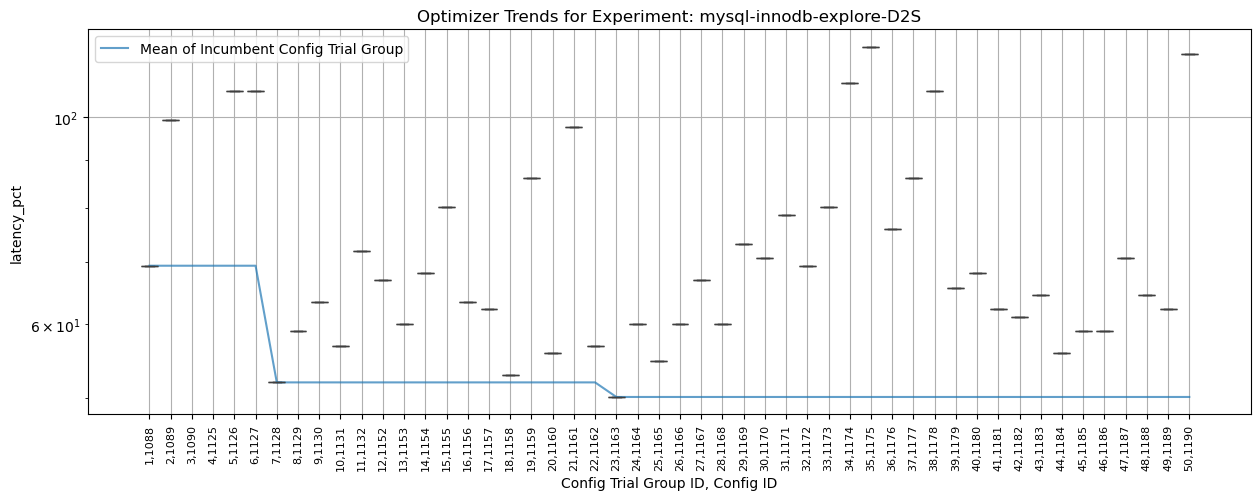

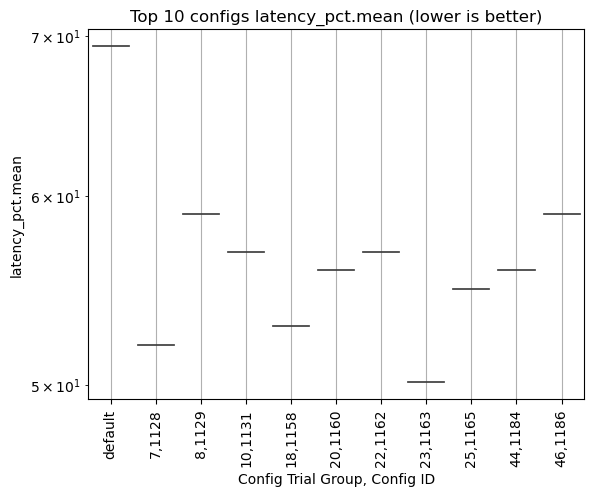

Target looks like regression


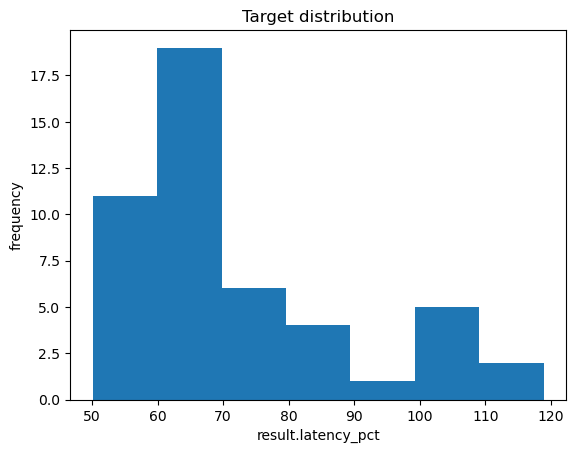

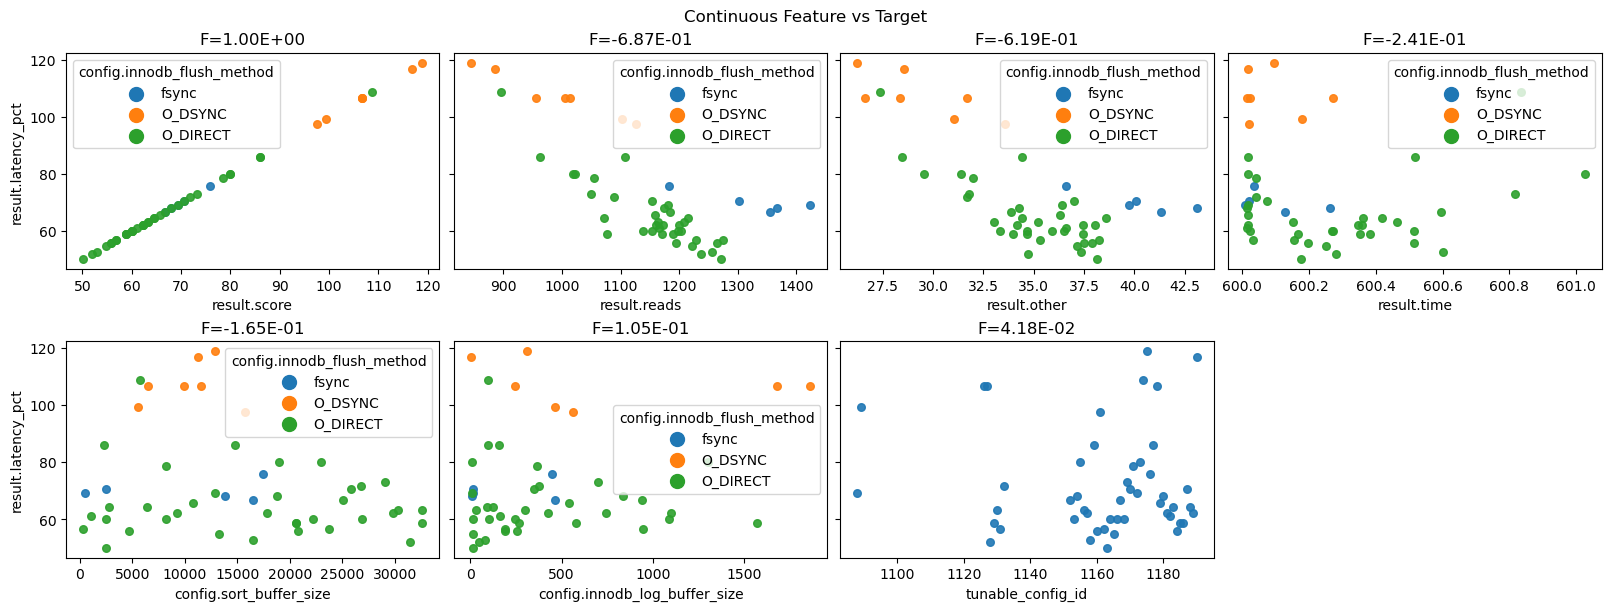

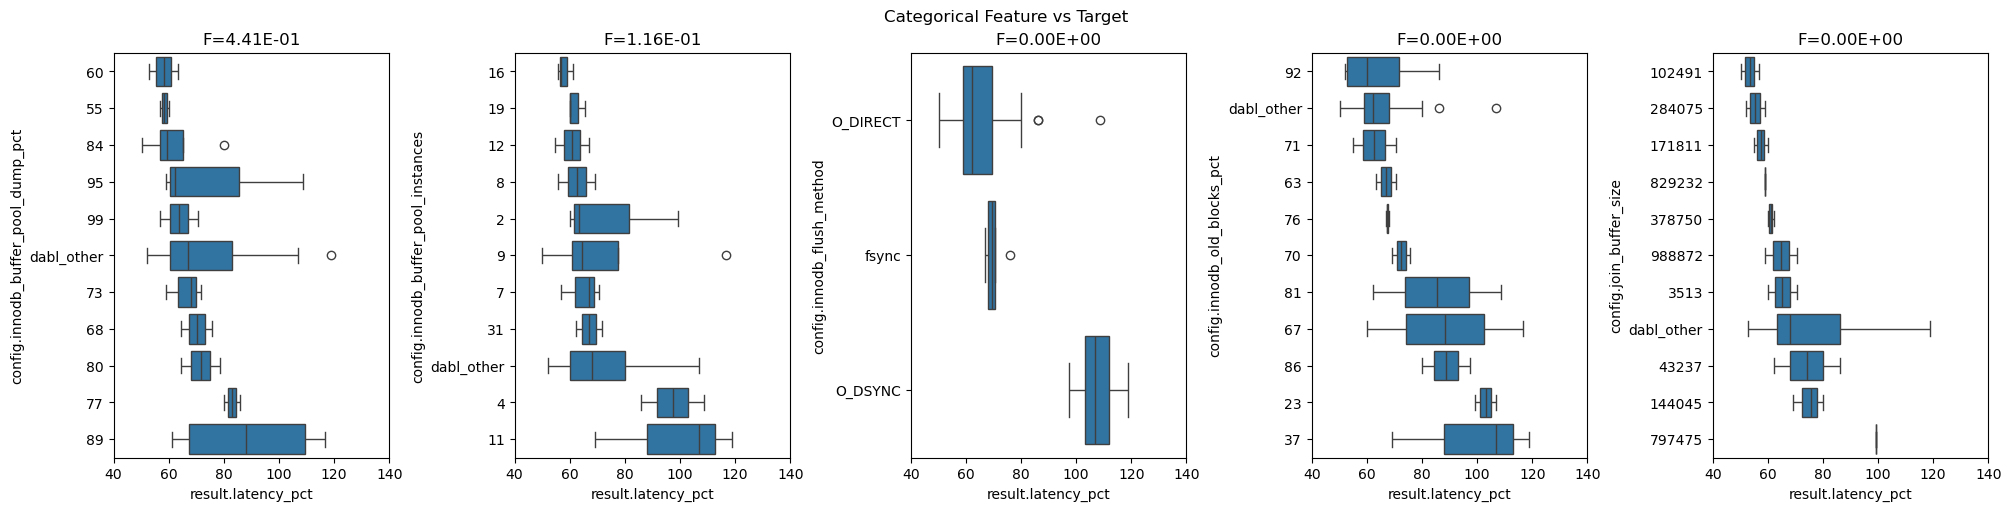

In [9]:
import mlos_viz
results_df = exp.results_df.head(50)
mlos_viz.plot(exp, results_df=results_df)

### Manually inspect the results

In [10]:
# The dataframe has a lot of columns. Let's just focus on a few of them.

# This is overall score that we are trying to improve.
# In this experiment, mlos_bench optimizer is minimizing the P95 tail latency.
SCORE = "result.latency_pct"
SCORE_LABEL = "P95 Tail Latency (ms)"

# Pick one configuration parameter and see how it influences the score.
PARAM1_LABEL = "innodb_buffer_pool_instances"
PARAM1 = "config." + PARAM1_LABEL

# We can also plot a system metric that might be influenced by the configuration.
# PARAM1 = "result.writes"

# A categorical configuration parameter is a great choice to add a color dimension to
# our plot. This way, we can visualize teh score and two configuration parameters at once.
PARAM2 = "config.innodb_flush_method"

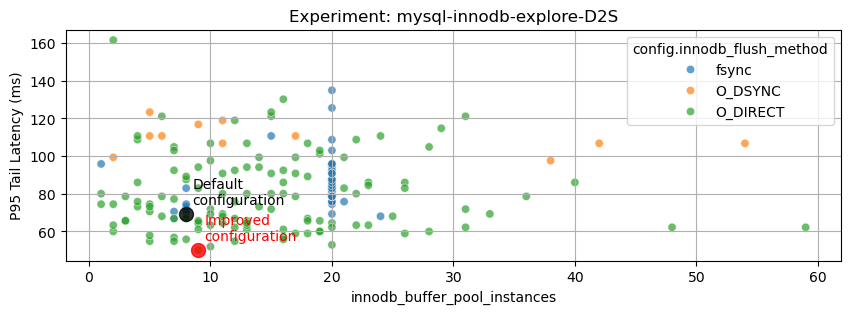

In [11]:
# Set the size of the figure.
plt.rcParams["figure.figsize"] = (10, 3)

# Create a scatter plot for that figure
sns.scatterplot(data=df, x=PARAM1, y=SCORE, hue=PARAM2, marker='o', alpha=0.7)

# Emphasize an area where the default config exists.

plt.scatter(x=default_config_trial[PARAM1], y=default_config_trial[SCORE], marker='o', s=100, color='black', alpha=0.8)
plt.text(default_config_trial[PARAM1] + 0.5, default_config_trial[SCORE] + 5, "Default\nconfiguration", horizontalalignment='left', size='medium', color='black')

# Emphasize an area some improved configs exists.
plt.scatter(x=best_trial[PARAM1], y=best_trial[SCORE], marker='o', s=100, color='red', alpha=0.8)
plt.text(best_trial[PARAM1] + 0.5, best_trial[SCORE] + 5, "Improved\nconfiguration", horizontalalignment='left', size='medium', color='red')

plt.xlabel(PARAM1_LABEL)
plt.ylabel(SCORE_LABEL)

plt.title("Experiment: " + exp.experiment_id)
plt.grid()
plt.show()

In this experiment, we allowed our `mlos_bench` optimizer to explore the configuration space and suggest new benchmark-worthy MySQL configurations. After conducting a number of trials, we picked the best-performing configuration and ran some more trials, comparing this new configuration with our baseline.

### 6. Look at some other experiment

After running a number of experiments and trials, we came up with a shortlist of promising MySQL configurations for more rigorous benchmarking and analysis. In this experiment, we run a large number of additional trials to compare two such configurations. Having many data samples, we can not only analyze the average performance of each configuration, but also look at the variance of the data and assess how robust each configuration is with respect to the fluctuations in the cloud performance.

In [12]:
exp_bench = storage.experiments["mysql-innodb-bseries-v346-vmcontrol"]
df_bench = exp_bench.results_df

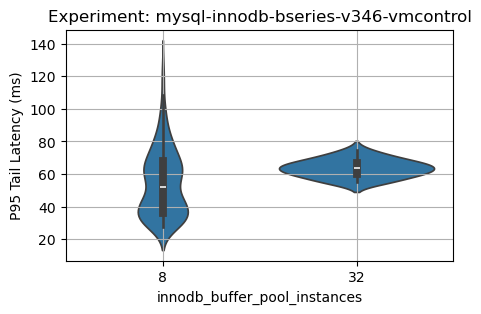

In [13]:
plt.rcParams["figure.figsize"] = (5, 3)

sns.violinplot(data=df_bench, x=PARAM1, y=SCORE)

plt.xlabel(PARAM1_LABEL)
plt.ylabel(SCORE_LABEL)

plt.title("Experiment: " + exp_bench.experiment_id)
plt.grid()
plt.show()

Here we see that the first configuration (which is actually our winner from the previous experiment) indeed has somewhat better latency on average. However, our other configuration is noticeably more robust and may be a better candidate for a new default MySQL setup on Azure.

----------------------

### 7. Extra: access the data of an individual trial

Sometimes we need to take a closer look at the data from the individual trial. The `ExperimentData.trials` property returns a Python `dict` of trial data records indexed by an integer trial ID.

In [14]:
trial = storage.experiments["mysql-innodb-buf"].trials[16]
trial

Trial :: mysql-innodb-buf:16 cid:1411 SUCCEEDED

Each such `TrialData` object allows us to access the configuration of a particular trial as a Pandas DataFrame:

In [15]:
trial.tunable_config.config_df

,parameter,value
0,innodb_buffer_pool_dump_pct,74
1,innodb_buffer_pool_instances,16
2,innodb_flush_method,O_DIRECT
3,innodb_log_buffer_size,663
4,innodb_old_blocks_pct,92
5,join_buffer_size,280313
6,sort_buffer_size,31080


Some trials can also have an addition key/value pairs of metadata associated with them. Here, for example, we see what optimizer was used to suggest this trial's configuration, and what the optimization target was. Again, the result is a Pandas DataFrame.

In [16]:
trial.metadata_df

,parameter,value
0,opt_direction,min
1,opt_target,score
2,optimizer,MlosCoreOptimizer:FlamlOptimizer


Similarly, we can retrieve a DataFrame with the benchmark metrics for the trial. Note that even though we optimize for the `score` metric (which is a copy of `latency_pct`), we also collect other metrics with each trial. This data can be reused later in other experiments with different optimziation targets. 

In [17]:
trial.results_df

,metric,value
0,errors,0.0
1,events,1731.702333
2,latency_pct,55.824272
3,other,35.176485
4,percentile,95.0
5,reads,1234.730116
6,reconnects,0.0
7,score,55.824272
8,threads,0.0
9,time,600.029641


Our framework can also collect some sideband telemetry data during the trial. Unlike the benchmark metrics used for the optimziation, the telemetry metrics can have multiple data points for each metric ID. The resulting DataFrame has three columns for the timestamp, metric ID, and metric value, respectively.

In [18]:
trial.telemetry_df

,ts,metric,value
0,2023-09-25 19:30:24+00:00,errors,0.0
1,2023-09-25 19:30:24+00:00,events,1770.030204
2,2023-09-25 19:30:24+00:00,latency_pct,50.107444
3,2023-09-25 19:30:24+00:00,other,36.048579
4,2023-09-25 19:30:24+00:00,percentile,95.0
...,...,...,...
115,2023-09-25 19:39:24+00:00,score,54.828067
116,2023-09-25 19:39:24+00:00,threads,30.0
117,2023-09-25 19:39:24+00:00,time,600.000436
118,2023-09-25 19:39:24+00:00,total,1728.884971


In this experiment, our telemetry has the same metrics as the final benchmark, but taken every 60 seconds over the course of the trial.

----------------------------------

### 8. Outro

If you feel curious, please go ahead and explore the MySQL data in the cells below.

After that, please open other notebooks in this repository and look at the SQLite optimization results:

* [**mlos_demo_sqlite.ipynb**](mlos_demo_sqlite.ipynb) - Use this notebook to analyze the data you've collected during this workshop.
* [**mlos_demo_sqlite_teachers.ipynb**](mlos_demo_sqlite_teachers.ipynb) - Teacher's copy, don't peek! :-) Here we analyze the data from 100 trials of SQLite optimization we ran in this codespace before the class. The results you get in the workshop should look similar.